# Import Modules and Set Up R&D Data Frame

In [1]:
# Import modules

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.style.use('ggplot')
import seaborn as sns
import squarify


In [2]:
# Dataset 1 is R&D data from Kaggle
ip = pd.read_csv("data/Top 2000 RD Companies.csv", sep=",")
ip.rename(columns={"Top 2000 R&D rank":"rank", "Company name":"company", "Company's headquarter location":"hq_country", "Industry":"industry", "R&D expenditures Share":"rdspend_share", "Patents Share":"patent_share", "Trademarks Share":"trademark_share"}, inplace=True)


In [3]:
ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rank             2000 non-null   int64  
 1   company          2000 non-null   object 
 2   hq_country       2000 non-null   object 
 3   industry         2000 non-null   object 
 4   rdspend_share    2000 non-null   float64
 5   patent_share     2000 non-null   float64
 6   trademark_share  2000 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 109.5+ KB


# Analysis A:  Country Analysis

### Set Up Country Analysis DataFrame

In [4]:
ip.hq_country.nunique()

39

In [5]:
# Set up data grouped by country
country_group = ip.groupby("hq_country")

# Apply aggregates
colFun = {'company':['count'],
          'rdspend_share':['sum'],
          'patent_share':['sum']}

country_analysis = country_group.agg(colFun)

# Rename columns
country_analysis = pd.DataFrame(country_analysis.to_records())  # flatten hierarchical index
country_analysis.columns = ["hq_country", "num_cos", "rd_share", "patent_share"]

In [6]:
# Dataset 2 is population data which will be used for per cap calculations, which will be merged with Dataset 1
pop = pd.read_csv("data/population.csv", sep=",", usecols = ["Country", "Population"])
pop.rename(columns={"Country":"hq_country", "Population":"pop"}, inplace = True)
country_analysis = pd.merge(left=country_analysis, right=pop, on="hq_country", how="left")

# Add population share
total_pop = pop['pop'].sum()
country_analysis['pop_share'] = country_analysis['pop']/total_pop


### Calculations

In [7]:
# Per capita calculations
country_analysis['num_co_per_mcapita'] = country_analysis['num_cos']/(country_analysis['pop']/1e6)
country_analysis['rd_share_to_pop_share'] = country_analysis['rd_share']/country_analysis['pop_share']
country_analysis['patent_share_to_pop_share'] = country_analysis['patent_share']/country_analysis['pop_share']

# Efficiency calculations
country_analysis['patent_eff'] = country_analysis['patent_share']/country_analysis['rd_share']


In [8]:
country_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 0 to 38
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   hq_country                 39 non-null     object 
 1   num_cos                    39 non-null     int64  
 2   rd_share                   39 non-null     float64
 3   patent_share               39 non-null     float64
 4   pop                        39 non-null     int64  
 5   pop_share                  39 non-null     float64
 6   num_co_per_mcapita         39 non-null     float64
 7   rd_share_to_pop_share      39 non-null     float64
 8   patent_share_to_pop_share  39 non-null     float64
 9   patent_eff                 39 non-null     float64
dtypes: float64(7), int64(2), object(1)
memory usage: 3.4+ KB


### Rank Metrics

In [9]:
# Add ranks
country_analysis['rank_num_cos'] = country_analysis['num_cos'].rank(ascending=False)
country_analysis['rank_rd_share'] = country_analysis['rd_share'].rank(ascending=False)
country_analysis['rank_patent_share'] = country_analysis['patent_share'].rank(ascending=False)
country_analysis['rank_pop_share'] = country_analysis['pop_share'].rank(ascending=False)
country_analysis['rank_num_co_pop'] = country_analysis['num_co_per_mcapita'].rank(ascending=False)
country_analysis['rank_rd_pop'] = country_analysis['rd_share_to_pop_share'].rank(ascending=False)
country_analysis['rank_patent_pop'] = country_analysis['patent_share_to_pop_share'].rank(ascending=False)
country_analysis['rank_patent_eff'] = country_analysis['patent_eff'].rank(ascending=False)


In [10]:
country_analysis.head()

,hq_country,num_cos,rd_share,patent_share,pop,pop_share,num_co_per_mcapita,rd_share_to_pop_share,patent_share_to_pop_share,patent_eff,rank_num_cos,rank_rd_share,rank_patent_share,rank_pop_share,rank_num_co_pop,rank_rd_pop,rank_patent_pop,rank_patent_eff
0,Argentina,1,0.009,0.000,45195774,0.010105,0.022126,0.890651,0.000000,0.000000,35.0,37.0,37.5,15.0,36.0,36.0,37.5,37.5
1,Australia,11,0.350,0.063,25499884,0.005701,0.431375,61.389293,11.050073,0.180000,21.5,20.0,22.5,19.0,25.0,22.0,29.0,33.0
2,Austria,13,0.184,0.242,9006398,0.002014,1.443418,91.375439,120.178567,1.315217,19.0,22.0,15.0,27.0,15.0,20.0,16.0,7.0
3,Belgium,11,0.330,0.177,11589623,0.002591,0.949125,127.352484,68.307241,0.536364,21.5,21.0,19.0,22.0,20.0,18.0,18.0,21.0
4,Brazil,6,0.126,0.030,212559417,0.047525,0.028227,2.651264,0.631253,0.238095,24.5,23.0,28.5,4.0,34.0,33.0,32.0,31.0


### Question: Which countries host the greatest number of Top 2,000 R&D Companies?

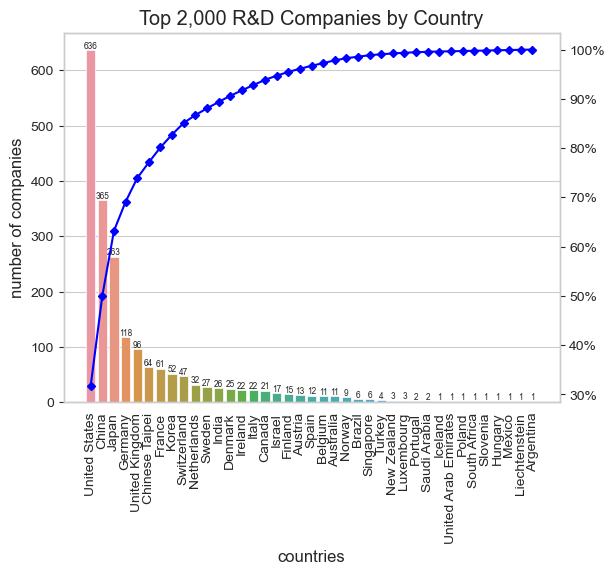

In [11]:
# Barplot

# Reorder by number of companies
ordered_df = country_analysis.sort_values(by='num_cos', ascending = False)

# Calculate cumulative percentage
ordered_df['cume_per'] = ordered_df['num_cos'].cumsum()/ordered_df['num_cos'].sum()*100


# Plot number of companies on Axis 1
sns.set_style("whitegrid")
ax = sns.barplot(y = 'num_cos',
            x = 'hq_country',
            data = ordered_df,
            orient = 'v')
ax.bar_label(ax.containers[0], fontsize=6)
plt.title('Top 2,000 R&D Companies by Country')
plt.ylabel('number of companies')
plt.xlabel('countries')
plt.xticks(rotation = 'vertical')

# Plot cume % of companies on Axis 2
ax2 = ax.twinx()
ax2.plot(ordered_df['hq_country'], ordered_df['cume_per'], color='blue', marker="D", ms=4)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.grid(False)

# Show graph
plt.show()

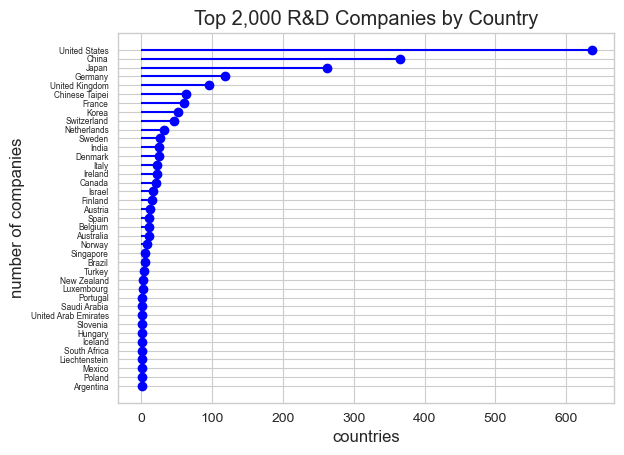

In [12]:
# Lollipop plot

# Reorder by number of companies
ordered_df = country_analysis.sort_values(by='num_cos', ascending = True)
my_range = range(1,len(country_analysis.index)+1)

# Plot data
plt.hlines(y = my_range, xmin = 0, xmax = ordered_df['num_cos'], color = 'blue')
plt.plot(ordered_df['num_cos'], my_range, "o", color = 'blue')

# Add text
plt.yticks(my_range, ordered_df['hq_country'], fontsize=6)
plt.title('Top 2,000 R&D Companies by Country')
plt.xlabel('countries')
plt.ylabel('number of companies')

# Show graph
plt.show()

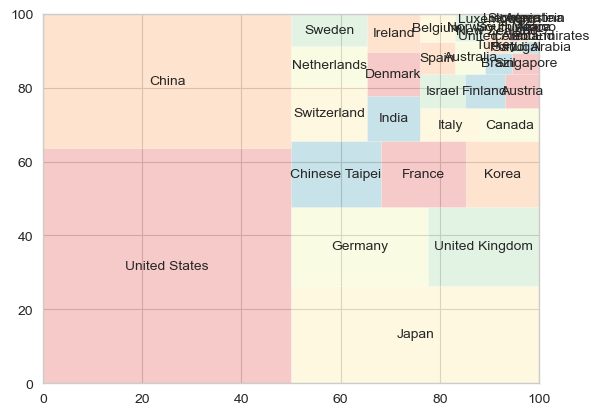

In [13]:
# Treemap

# Reorder by number of companies
ordered_df = country_analysis.sort_values(by='num_cos', ascending = False)

# Plot data
squarify.plot(sizes = ordered_df['num_cos'],
              label = ordered_df['hq_country'],
              color = sns.color_palette("Spectral"),
              alpha=.3)

# Show graph
plt.show()

### Question: Which countries have the highest R&D expenditure share within the sample?

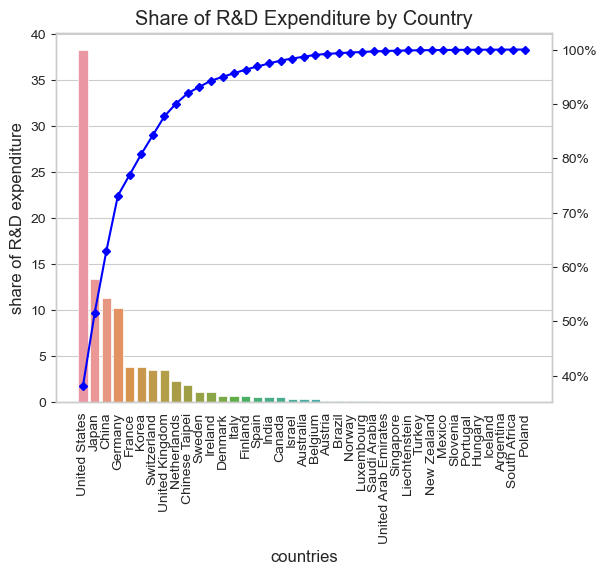

In [14]:
# Barplot

# Reorder by R&D share
ordered_df = country_analysis.sort_values(by='rd_share', ascending = False)

# Calculate cumulative percentage
ordered_df['cume_per'] = ordered_df['rd_share'].cumsum()/ordered_df['rd_share'].sum()*100


# Plot number of companies on Axis 1
sns.set_style("whitegrid")
ax = sns.barplot(y = 'rd_share',
            x = 'hq_country',
            data = ordered_df,
            orient = 'v')
plt.title('Share of R&D Expenditure by Country')
plt.ylabel('share of R&D expenditure')
plt.xlabel('countries')
plt.xticks(rotation = 'vertical')

# Plot cume % of companies on Axis 2
ax2 = ax.twinx()
ax2.plot(ordered_df['hq_country'], ordered_df['cume_per'], color='blue', marker="D", ms=4)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.grid(False)

# Show graph
plt.show()

### Question: Which countries have the highest patent share within the sample?

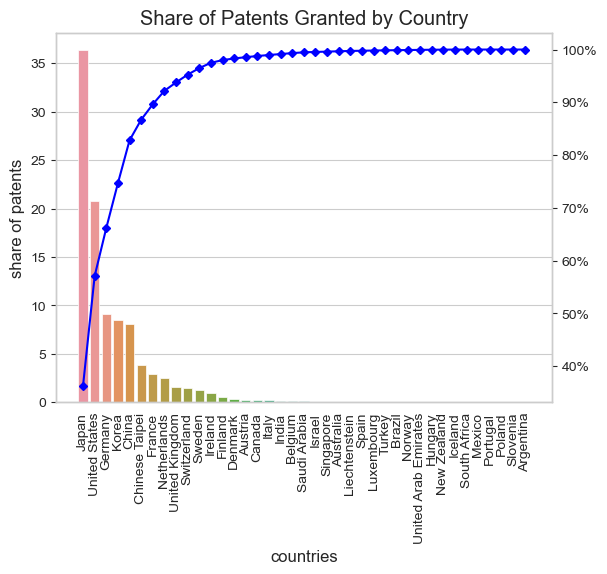

In [15]:
# Barplot

# Reorder by patent share
ordered_df = country_analysis.sort_values(by='patent_share', ascending = False)

# Calculate cumulative percentage
ordered_df['cume_per'] = ordered_df['patent_share'].cumsum()/ordered_df['patent_share'].sum()*100


# Plot number of companies on Axis 1
sns.set_style("whitegrid")
ax = sns.barplot(y = 'patent_share',
            x = 'hq_country',
            data = ordered_df,
            orient = 'v')
plt.title('Share of Patents Granted by Country')
plt.ylabel('share of patents')
plt.xlabel('countries')
plt.xticks(rotation = 'vertical')

# Plot cume % of companies on Axis 2
ax2 = ax.twinx()
ax2.plot(ordered_df['hq_country'], ordered_df['cume_per'], color='blue', marker="D", ms=4)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.grid(False)

# Show graph
plt.show()

### Question: How do these answers change if we normalize by population i.e. use per capita figures?

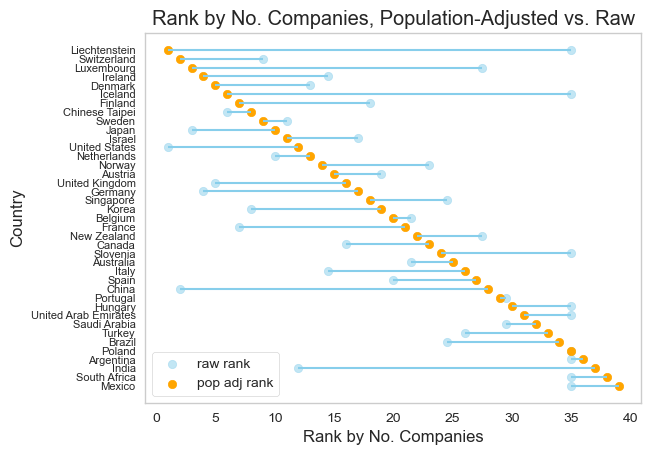

In [68]:
# Rank by Number of Companies - Lollipop chart with 2 observation series

# Create a new dataframe to compare raw ranks and pop adj ranks
value1 = country_analysis['rank_num_cos']
value2 = country_analysis['rank_num_co_pop']
df = pd.DataFrame({'country':country_analysis['hq_country'], 'raw rank':value1, 'pop adj rank':value2})

# Reorder based on the pop adj rank
ordered_df = df.sort_values(by='pop adj rank', ascending = False)
my_range = range(1, len(df.index)+1)

# Plot the data
plt.hlines(y = my_range, xmin = ordered_df['pop adj rank'], xmax = ordered_df['raw rank'], color='skyblue', alpha = 1)
plt.scatter(ordered_df['raw rank'], my_range, color='skyblue', alpha=.5, label='raw rank')
plt.scatter(ordered_df['pop adj rank'], my_range, color='orange', alpha=1, label='pop adj rank')
plt.grid(False)
plt.legend()

# Add title and axis data
plt.yticks(my_range, ordered_df['country'], fontsize =8)
plt.title("Rank by No. Companies, Population-Adjusted vs. Raw")
plt.xlabel("Rank by No. Companies")
plt.ylabel("Country")

# Show graph
plt.show()


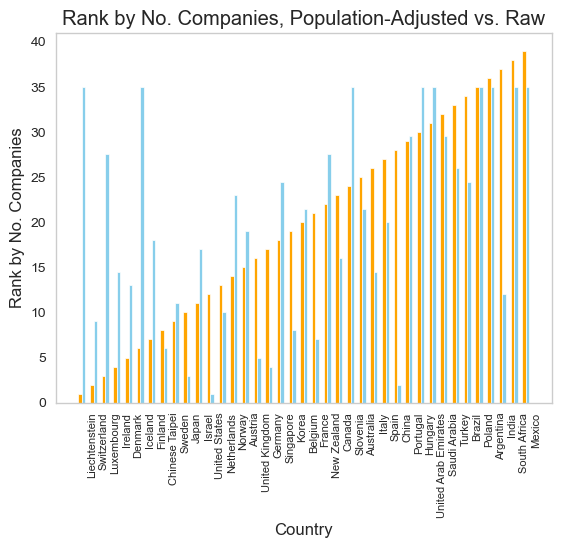

In [69]:
# Barplot with 2 observation series

# Create a new dataframe to compare raw ranks and pop adj ranks
value1 = country_analysis['rank_num_co_pop']
value2 = country_analysis['rank_num_cos']
df = pd.DataFrame({'country':country_analysis['hq_country'], 'pop adj rank':value1, 'raw rank':value2})

# Reorder based on the pop adj rank
ordered_df = df.sort_values(by='pop adj rank', ascending = True)
my_range = range(1, len(df.index)+1)

# Create bars
barWidth = 0.3
bars1 = ordered_df['pop adj rank']
bars2 = ordered_df['raw rank']

# x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Create raw bars
plt.bar(r1, bars1, width = barWidth, color = 'orange')
plt.bar(r2, bars2, width = barWidth, color = 'skyblue')

# Add title and axis data
plt.xticks(my_range, ordered_df['country'], rotation = 90, fontsize = 8)
plt.title("Rank by No. Companies, Population-Adjusted vs. Raw")
plt.xlabel("Country")
plt.ylabel("Rank by No. Companies")
plt.grid(False)

# Show graph
plt.show()



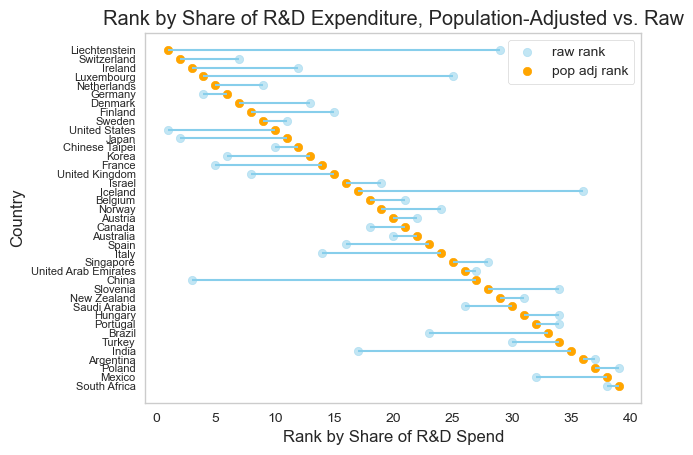

In [70]:
# Rank by R&D Expenditure Share - Lollipop chart with 2 observation series

# Create a new dataframe to compare raw ranks and pop adj ranks
value1 = country_analysis['rank_rd_share']
value2 = country_analysis['rank_rd_pop']
df = pd.DataFrame({'country':country_analysis['hq_country'], 'raw rank':value1, 'pop adj rank':value2})

# Reorder based on the pop adj rank
ordered_df = df.sort_values(by='pop adj rank', ascending = False)
my_range = range(1, len(df.index)+1)

# Plot the data
plt.hlines(y = my_range, xmin = ordered_df['pop adj rank'], xmax = ordered_df['raw rank'], color='skyblue', alpha = 1)
plt.scatter(ordered_df['raw rank'], my_range, color='skyblue', alpha=.5, label='raw rank')
plt.scatter(ordered_df['pop adj rank'], my_range, color='orange', alpha=1, label='pop adj rank')
plt.grid(False)
plt.legend()

# Add title and axis data
plt.yticks(my_range, ordered_df['country'], fontsize = 8)
plt.title("Rank by Share of R&D Expenditure, Population-Adjusted vs. Raw")
plt.xlabel("Rank by Share of R&D Spend")
plt.ylabel("Country")

# Show graph
plt.show()

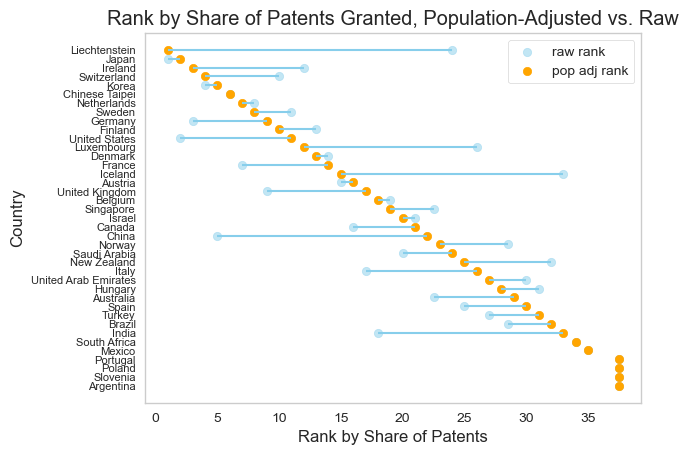

In [71]:
# Rank by Patent Share - Lollipop chart with 2 observation series

# Create a new dataframe to compare raw ranks and pop adj ranks
value1 = country_analysis['rank_patent_share']
value2 = country_analysis['rank_patent_pop']
df = pd.DataFrame({'country':country_analysis['hq_country'], 'raw rank':value1, 'pop adj rank':value2})

# Reorder based on the pop adj rank
ordered_df = df.sort_values(by='pop adj rank', ascending = False)
my_range = range(1, len(df.index)+1)

# Plot the data
plt.hlines(y = my_range, xmin = ordered_df['pop adj rank'], xmax = ordered_df['raw rank'], color='skyblue', alpha = 1)
plt.scatter(ordered_df['raw rank'], my_range, color='skyblue', alpha=.5, label='raw rank')
plt.scatter(ordered_df['pop adj rank'], my_range, color='orange', alpha=1, label='pop adj rank')
plt.grid(False)
plt.legend()

# Add title and axis data
plt.yticks(my_range, ordered_df['country'], fontsize = 8)
plt.title("Rank by Share of Patents Granted, Population-Adjusted vs. Raw")
plt.xlabel("Rank by Share of Patents")
plt.ylabel("Country")

# Show graph
plt.show()

### Question: Are the per cap results potentially explained by favorable taxation?

In [20]:
# Create list of favorable tax jurisdictions from https://en.wikipedia.org/wiki/Tax_haven#Top_10_tax_havens
fav_tax_jur = ['Bermuda',
               'British Virgin Islands',
               'Cayman Islands',
               'Ireland',
               'Hong Kong',
               'Jersey',
               'Luxembourg',
               'Netherlands',
               'Puerto Rico',
               'Singapore']

# Create a new dataframe to find companies located in favorable tax jurisdictions
df = pd.DataFrame().assign(company = ip['company'],
                           country = ip['hq_country'])
df['fav_tax'] = df['country'].isin(fav_tax_jur)
fav_tax_cos = df.loc[df['fav_tax'] == True]
fav_tax_cos = fav_tax_cos.sort_values(by='company', ascending = True)

# Show the companies
print(fav_tax_cos)


                                company      country  fav_tax
215                           ACCENTURE      Ireland     True
617                              ADIENT      Ireland     True
604                               AHOLD  Netherlands     True
47                               AIRBUS  Netherlands     True
491                          AKZO NOBEL  Netherlands     True
...                                 ...          ...      ...
1009                 WAVE LIFE SCIENCES    Singapore     True
898           WEATHERFORD INTERNATIONAL      Ireland     True
1727                     WRIGHT MEDICAL  Netherlands     True
439                              YANDEX  Netherlands     True
1019  ZUIVELCOOPERATIE FRIESLANDCAMPINA  Netherlands     True

[63 rows x 3 columns]


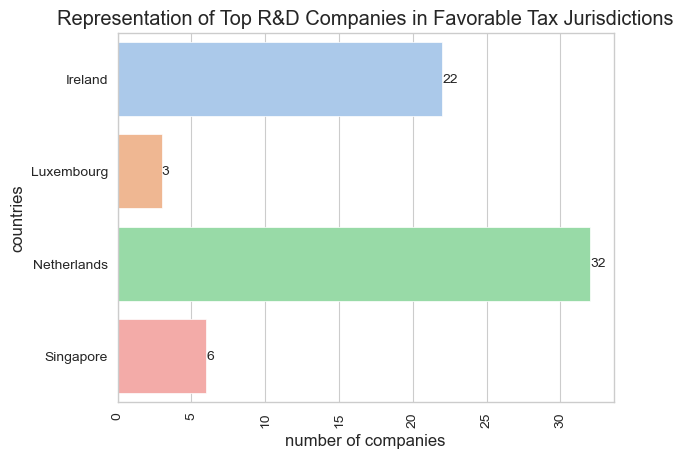

In [63]:
# Group the dataframe by country
df = fav_tax_cos.groupby("country").count()
df = pd.DataFrame(df.to_records())

# Barplot number of companies
sns.set_style("whitegrid")
ax = sns.barplot(x = 'company',
                 y = 'country',
                 data = df,
                 orient = 'h',
                 palette = 'pastel')
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Representation of Top R&D Companies in Favorable Tax Jurisdictions')
plt.xlabel('number of companies')
plt.ylabel('countries')
plt.xticks(rotation = 'vertical')

# Show graph
plt.show()

### Question: Which countries produce the greatest share of patents per dollar expenditure in the sample?

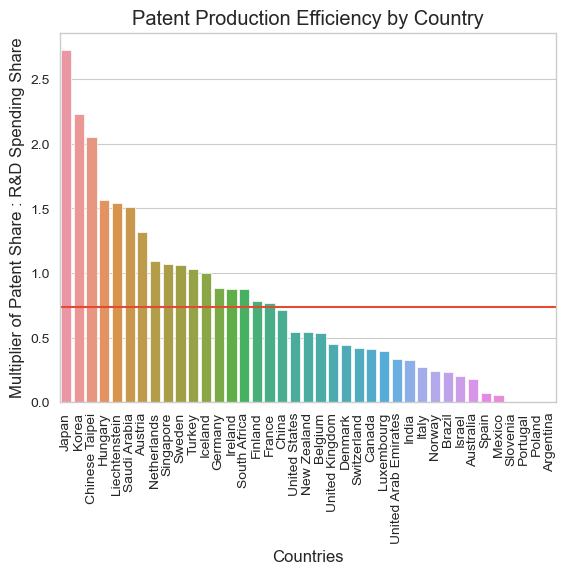

In [72]:
# Barplot of Patent Efficiency Metric
sns.barplot(x = 'hq_country',
            y = 'patent_eff',
            data = country_analysis,
            order = country_analysis.sort_values('patent_eff', ascending = False).hq_country)

# Axes and Labels
plt.xticks(rotation=90)
plt.title('Patent Production Efficiency by Country')
plt.xlabel('Countries')
plt.ylabel('Multiplier of Patent Share : R&D Spending Share')

# Draw a line at the average multiplier value
plt.axhline(y = country_analysis['patent_eff'].mean())

# Show graph
plt.show()


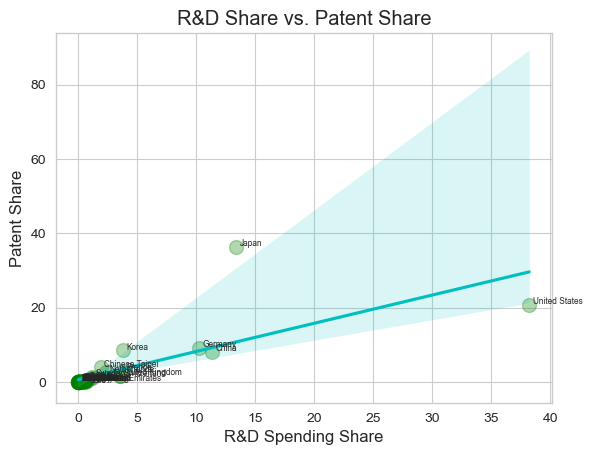

In [73]:
# Scatterplot with Linear Regression

# Draw scatterplot
df = country_analysis

sns.set_style('whitegrid')

sns.regplot(x = 'rd_share', 
            y = 'patent_share',
            data = df,
            scatter_kws = {"color":"green", "alpha":0.3, "s":100},
            line_kws = {"color":"c"},
           )

# Axes and Labels
plt.title('R&D Share vs. Patent Share')
plt.xlabel('R&D Spending Share')
plt.ylabel('Patent Share')

# Add labels
for i in range(df.shape[0]):
    plt.text(x = df.rd_share[i]+0.3, y = df.patent_share[i]+0.3, s=df.hq_country[i],
    fontdict = dict(size = 6))

    
    
plt.show()


# Analysis B:  Industry Analysis
## (1) Which industries host the greatest number of companies in the Top 2000 R&D ranks?
## (2) Which industries have the highest R&D expenditure share if we sum the companies in the Top 2000 R&D ranks?
## (3) Which industries have the highest patent share if we sum the companies in the Top 2000 R&D ranks?
## (4) Which industries have the highest efficiency of patent production per dollar expenditure given the Top 2000

In [ ]:
# Set up data grouped by industry
industry_group = ip.groupby("industry")

# Apply aggregates (Part a-c)
colFun = {'industry':['count'],
          'rdspend_share':['sum'],
          'patent_share':['sum']}

industry_analysis = industry_group.agg(colFun)

# Rename columns
industry_analysis = pd.DataFrame(industry_analysis.to_records())  # flatten hierarchical index
industry_analysis.columns = ["industry", "num_cos", "rd_share", "patent_share"]

In [ ]:
industry_analysis.head()

In [ ]:
# Calculate patent efficiency (Part d)
industry_analysis['patent_eff'] = industry_analysis['patent_share']/industry_analysis['rd_share']
industry_analysis['rank_patent_eff'] = industry_analysis['patent_eff'].rank(ascending=False)


In [ ]:
industry_analysis


# Analysis C:  Company Analysis
## (1) Which companies have the highest patent share of the top 2000?
## (2) Which companies have the highest efficiency of patent production per dollar expenditure within the top 2000?
## (3) Which companies are best and worst in their industry by patent share?
## (4) Which companies are best and worst in their industry by patent efficiency?

In [ ]:
# Set up the raw data
company_analysis = ip

# Calculate ranks for R&D expenditure share, patent share, and trademark share
company_analysis['rank_rdspend_share'] = company_analysis['rdspend_share'].rank(ascending=False)
company_analysis['rank_patent_share'] = company_analysis['patent_share'].rank(ascending=False)
company_analysis['rank_trademark_share'] = company_analysis['trademark_share'].rank(ascending=False)

# Calculate patent efficiency
company_analysis['patent_eff'] = company_analysis['patent_share']/company_analysis['rdspend_share']
company_analysis['rank_patent_eff'] = company_analysis['patent_eff'].rank(ascending=False)


In [ ]:
# Sort by patent share (Part a)

company_analysis.sort_values("rank_patent_share",ascending = True).head(20)

In [ ]:
# Sort by patent efficiency (Part b)

company_analysis.sort_values("rank_patent_eff",ascending = True).head(20)

In [ ]:
# Sort by industry by company for patent share (Part C)

ind_co_1 = pd.DataFrame().assign(company=company_analysis['company'], 
                               industry=company_analysis['industry'],
                               rank_patent_share=company_analysis['rank_patent_share']
                              )

ind_co_1 = ind_co_1.sort_values(["rank_patent_share"], ascending=True).groupby("industry")

for key, values in ind_co_1:
    print(key)
    print("-"*70)
    print(values)
    print("\n")

In [ ]:
# Sort by industry by company for patent share (Part D)

ind_co_2 = pd.DataFrame().assign(company=company_analysis['company'], 
                               industry=company_analysis['industry'],
                               rank_patent_eff=company_analysis['rank_patent_eff']
                              )

ind_co_2 = ind_co_2.sort_values(["rank_patent_eff"], ascending=True).groupby("industry")

for key, values in ind_co_2:
    print(key)
    print("-"*70)
    print(values)
    print("\n")

In [ ]:
# POTENTIAL ANALYSIS: How does FANGNAM compare?